In [1]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
import pandas as pd
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
import numpy as np
from tqdm import tqdm
from speechbrain.pretrained.interfaces import foreign_class


model_voxlingua = "speechbrain/lang-id-voxlingua107-ecapa"
model_commonlanguage = "speechbrain/lang-id-commonlanguage_ecapa"
model_TalTech_wav2vec = "TalTechNLP/voxlingua107-xls-r-300m-wav2vec"

# model = EncoderClassifier.from_hparams(source=model_TalTech_wav2vec, savedir="tmp")
model = foreign_class(source="TalTechNLP/voxlingua107-xls-r-300m-wav2vec", pymodule_file="encoder_wav2vec_classifier.py", classname="EncoderWav2vecClassifier", hparams_file='inference_wav2vec.yaml', savedir="tmp")


/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/lorenzg/miniconda3/envs/dicla_torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were no

In [2]:
# signal, fs = torchaudio.load("/home/projects/vokquant/data/dicla/processed_16khz_renamed/IR_MJ/31110_IR_MJ_141.05.wav")

# embedding = model.encode_batch(signal)

# # If you want to convert it to a numpy array (optional)
# embedding_numpy = embedding.squeeze(0).cpu().numpy()
# print(embedding_numpy)
def get_embedding(file_path):
    signal, fs = torchaudio.load(file_path)
    # check if stereo
    if signal.shape[0] >= 2:
        signal = signal.mean(dim=0, keepdim=True)
        # print(f"stereo signal, converting to mono: {signal.shape}")
    embedding = model.encode_batch(signal)
    return embedding.squeeze(0).cpu().numpy()

emb_test = get_embedding("/home/projects/vokquant/data/dicla/processed_16khz_renamed/IR_MJ/31110_IR_MJ_141.05.wav")
print(f"emb_test shape: {emb_test.shape}")

emb_test shape: (1, 2048)


# TalTech

In [ ]:
# # read test items
# test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_augmented_dev'
# test_items = pd.read_csv(f'{test_path}/train.csv')
# embeddings = []
# accents = []

# # output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb"
# # save_path = os.path.join(output_folder, "embeddings")

# # go through all test items and get embeddings
# for index, row in tqdm(test_items.iterrows()):
#     # filepath = f"{test_path}/test/{row['utt_id']}.wav"
#     filepath = f"{row['wav']}"
#     # filename = test_items.iloc[index].utt_id #filepath.split("/")[-1].replace(".wav", ".npy").replace(".mp3", ".npy")
#     emb = get_embedding(filepath)    
#     accent = row['accent']
#     embeddings.append(emb)
#     accents.append(accent)

# embeddings = np.array(embeddings)
# print("Embeddings shape: ", np.shape(embeddings))
# print("Accents shape: ", np.shape(accents))

# # check for each item in embeddings
# for emb in embeddings:
#     if emb.shape == (1, 256) or emb.shape == (1,2048):
#         # print("Shape correct")
#         continue
#     else:
#         print("Shape not correct")
#         print(emb.shape)

In [7]:
import concurrent.futures
import numpy as np
import pandas as pd
from tqdm import tqdm

test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_augmented_dev'
test_items = pd.read_csv(f'{test_path}/test.csv')

embeddings2 = []
accents2 = []

# Define a function to process each row
def process_row(row):
    filepath = f"{row['wav']}"
    emb = get_embedding(filepath)
    accent = row['accent']
    return emb, accent

# Use ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Process the rows in parallel and ensure the order is maintained
    results2 = list(tqdm(executor.map(process_row, [row for _, row in test_items.iterrows()]), total=len(test_items)))

# Unpack results into embeddings2 and accents2
embeddings2, accents2 = zip(*results2)

embeddings2 = np.array(embeddings2)
print("Embeddings shape: ", np.shape(embeddings2))
print("Accents shape: ", np.shape(accents2))
accents2 = list(accents2)
# Check for each item in embeddings2
for emb in embeddings2:
    if emb.shape == (1, 256) or emb.shape == (1,2048):
        # print("Shape correct")
        continue
    else:
        print("Shape not correct")
        print(emb.shape)


100%|██████████| 998/998 [01:42<00:00,  9.78it/s]


Embeddings shape:  (998, 1, 2048)
Accents shape:  (998,)


In [36]:
# #check if embeddings are the same
# assert np.allclose(embeddings, embeddings2)
# # seems to work!
# # convert accents2 from tuple to list
# accents2 = list(accents2)
# assert accents == accents2

In [8]:
import seaborn as sns
accents = accents2
embeddings = embeddings2
accents_unique = np.unique(accents)
print("Unique accents: ", accents_unique)
# print("accents: ", accents)
# print("embeddings: ", embeddings)
# make dictionary of embeddings
embeddings_dict = {}
# combine embeddings with accents
for i, accent in enumerate(accents):
    if accent not in embeddings_dict:
        embeddings_dict[accent] = []
    embeddings_dict[accent].append(embeddings[i])

# number 1 is for Burgenland, 2 for Kärnten, 3 for Niederösterreich, 4 for Oberösterreich, 5 for Salzburg, 6 for Steiermark, 7 for Tirol, 8 for Vorarlberg
classes = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich', 'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg']
# make label encoding starting from 1
label_encoding = {classes[i]: i+1 for i in range(len(classes))}
print("Label encoding: ", label_encoding)
switched_label_encoding = {v: k for k, v in label_encoding.items()}
print("Switched label encoding: ", switched_label_encoding)

# for key 1 in embeddings_dict print the embeddings
for key in embeddings_dict:
    # print(f"Accent: {key}, Number of samples: {len(embeddings_dict[key])}")
    if key == 1:
        # print("key 1: Burgenland")
        accent_embeddings_Burg = embeddings_dict[key]
    elif key == 2:
        # print("key 2: Kärnten")
        accent_embeddings_Kaer = embeddings_dict[key]
    elif key == 3:
        # print("key 3: Niederösterreich")
        accent_embeddings_Nied = embeddings_dict[key]
    elif key == 4:
        # print("key 4: Oberösterreich")
        accent_embeddings_Ober = embeddings_dict[key]
    elif key == 5:
        # print("key 5: Salzburg")
        accent_embeddings_Salz = embeddings_dict[key]
    elif key == 6:
        # print("key 6: Steiermark")
        accent_embeddings_Steier = embeddings_dict[key]
    elif key == 7:
        # print("key 7: Tirol")
        accent_embeddings_Tirol = embeddings_dict[key]
    elif key == 8:
        # print("key 8: Vorarlberg")
        accent_embeddings_Voral = embeddings_dict[key]

Unique accents:  [1 2 3 4 5 6 7 8]
Label encoding:  {'Burgenland': 1, 'Kärnten': 2, 'Niederösterreich': 3, 'Oberösterreich': 4, 'Salzburg': 5, 'Steiermark': 6, 'Tirol': 7, 'Vorarlberg': 8}
Switched label encoding:  {1: 'Burgenland', 2: 'Kärnten', 3: 'Niederösterreich', 4: 'Oberösterreich', 5: 'Salzburg', 6: 'Steiermark', 7: 'Tirol', 8: 'Vorarlberg'}


All embeddings shape:  (998, 2048)
All embeddings reduced shape:  (998, 2)


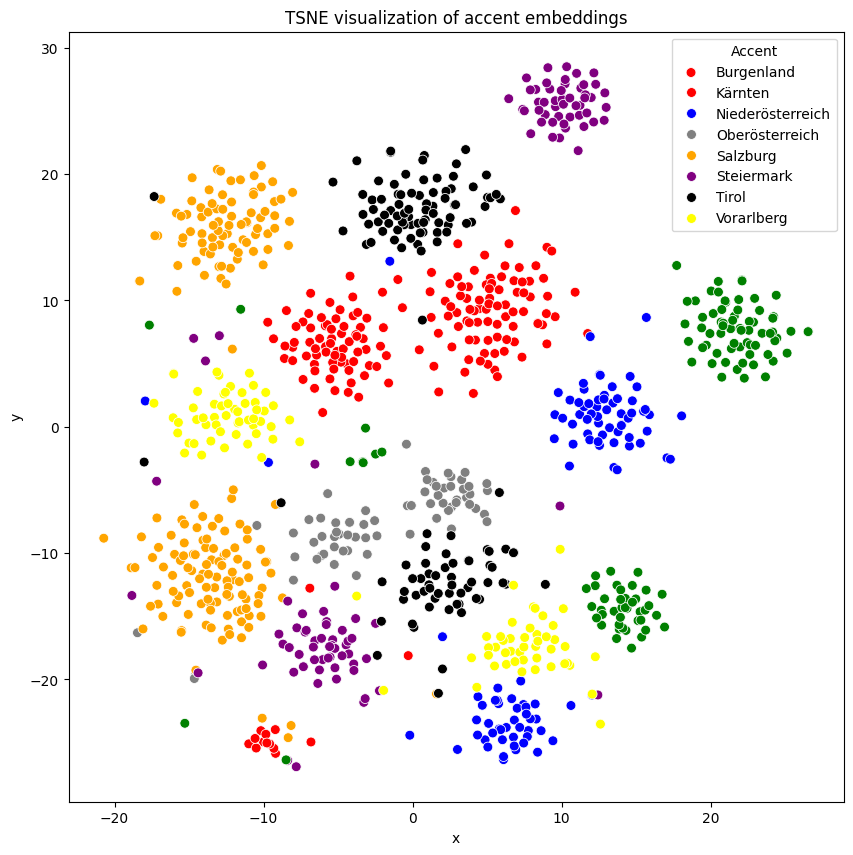

In [9]:
# visualize embeddings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# combine all embeddings
all_embeddings = np.concatenate((accent_embeddings_Burg, accent_embeddings_Kaer, accent_embeddings_Nied, accent_embeddings_Ober, accent_embeddings_Salz, accent_embeddings_Steier, accent_embeddings_Tirol, accent_embeddings_Voral), axis=0)
# unsqueeze middle dimension
all_embeddings = np.squeeze(all_embeddings, axis=1)
print("All embeddings shape: ", np.shape(all_embeddings))

# create labels
labels = []
for i in range(1, 9):
    labels += [i] * len(embeddings_dict[i])
# print("Labels: ", labels)

# reduce dimensionality
tsne = TSNE(n_components=2, random_state=0)
all_embeddings_reduced = tsne.fit_transform(all_embeddings)
print("All embeddings reduced shape: ", np.shape(all_embeddings_reduced))

# create dataframe
df = pd.DataFrame(all_embeddings_reduced, columns=['x', 'y'])
df['accent'] = labels
# print("Dataframe: ", df)

# plot
plt.figure(figsize=(10, 10))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']

sns.scatterplot(data=df, x='x', y='y', hue='accent', palette=colors, s=50)
plt.title('TSNE visualization of accent embeddings')
# make legen labels to be accent names
plt.legend(title='Accent', loc='upper right', labels=classes)
plt.show()



All embeddings reduced shape:  (1001, 2)


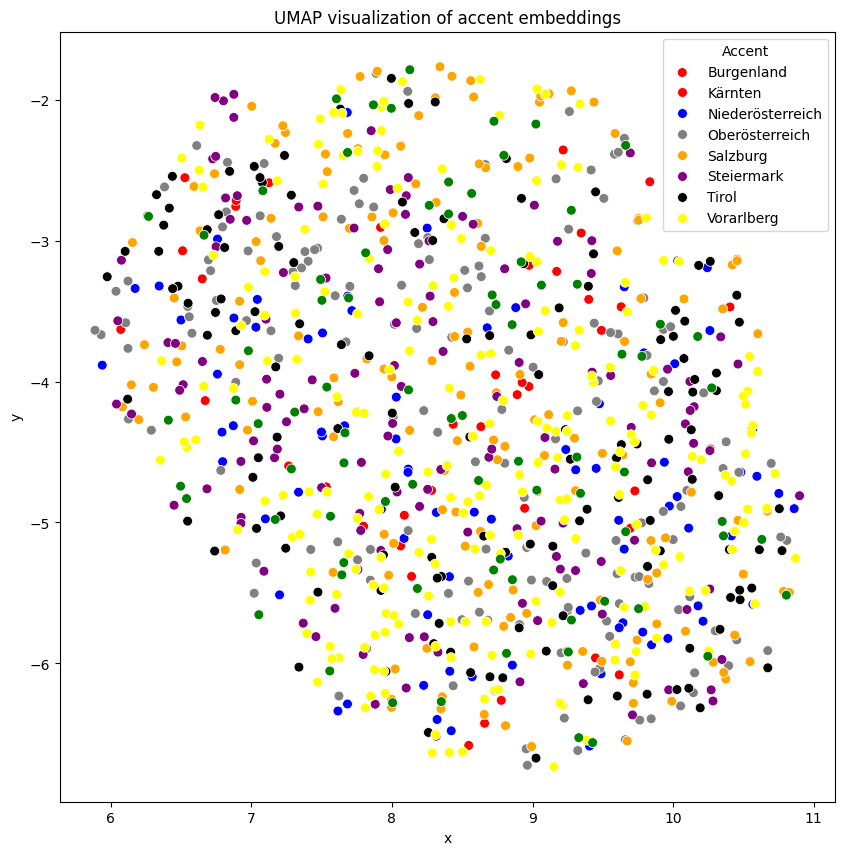

In [52]:
import umap

# reduce dimensionality
reducer = umap.UMAP()  # Adjust parameters based on your needs
all_embeddings_reduced = reducer.fit_transform(all_embeddings)
print("All embeddings reduced shape: ", np.shape(all_embeddings_reduced))

# create dataframe
df = pd.DataFrame(all_embeddings_reduced, columns=['x', 'y'])
df['accent'] = labels
# print("Dataframe: ", df)

# plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='accent', palette=colors, s=50)
plt.title('UMAP visualization of accent embeddings')
# make legen labels to be accent names
plt.legend(title='Accent', loc='upper right', labels=classes)
plt.show()


All embeddings reduced shape:  (1001, 2)


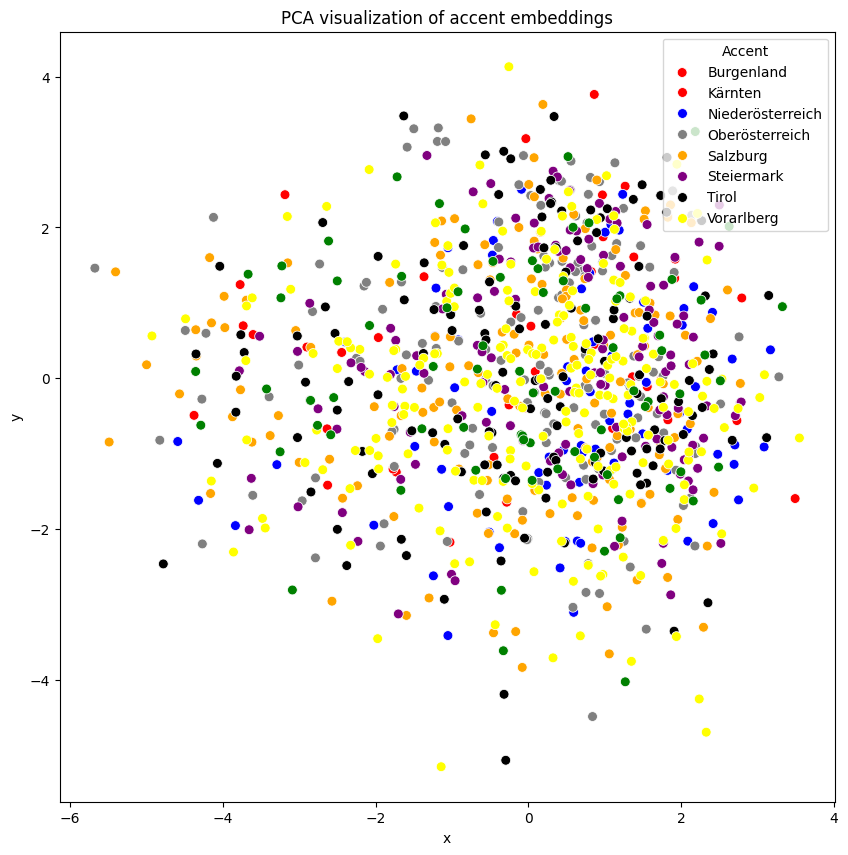

In [46]:
# pca
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
all_embeddings_reduced = pca.fit_transform(all_embeddings)
print("All embeddings reduced shape: ", np.shape(all_embeddings_reduced))

# create dataframe
df = pd.DataFrame(all_embeddings_reduced, columns=['x', 'y'])
df['accent'] = labels
# print("Dataframe: ", df)

# plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='accent', palette=colors, s=50)
plt.title('PCA visualization of accent embeddings')
# make legen labels to be accent names
plt.legend(title='Accent', loc='upper right', labels=classes)
plt.show()
